# Term frequency - Inverse document frequency (TF-IDF)

In [56]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [57]:
from sailor import SailorDataEngineer, RouteGenConfig
from sklearn.model_selection import train_test_split

from sailor.route_specs import NavigationContext

_config = RouteGenConfig(
  api_key=os.getenv("AI_API_KEY"), # type: ignore
  model=os.getenv("AI_MODEL"), # type: ignore
  base_url=os.getenv("AI_MODEL_URL"),
  cache_dir="../build/cache")


_context = "flight agency"
_cache_key = "flight_agency"

_engineer = SailorDataEngineer(_config)
_routes_context = await _engineer.generate_data(route_context=_context, cache_key=_cache_key)
if _routes_context is None:
    raise ValueError("No data generated")

routes_context: NavigationContext = _routes_context
train_sessions, test_sessions = train_test_split(routes_context.sessions, test_size=0.2, random_state=1)

In [58]:
from sailor import TfidfSailorEngine

engine = TfidfSailorEngine(routes=routes_context.routes)
engine.train(train_sessions)

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 292 stored elements and shape (36, 179)>,
 array([13, 12, 17, 34,  8, 14,  5, 11, 30, 25, 21,  7,  3, 28, 33, 20, 16,
        15, 18,  2,  9, 35, 10, 24,  1, 19, 29,  6, 22, 23, 27, 31,  4, 32,
        26,  0]))

## 3. Validate vectorizer 

### 3.1. Test vectorizer

In [59]:
import time

def _test_query(query):
    start_time = time.time()
    results = engine.predict(query)
    latency = (time.time() - start_time)*1000
    print(f"Results ({latency:.2f}ms):")

    for route, score in results[:5]:
        print(f"- {route.path} (score: {score:.3f})")

for session in test_sessions:
    for route in routes_context.routes:
        if route.id == session.route_id:
            break

    query = session.intention.context
    print(f"Query: '{query}'; Expected route: {route.path};")
    _test_query(query)

Query: 'Clicked on the 'special assistance' link'; Expected route: /special-assistance;
Results (3.18ms):
- /flights/search (score: 0.807)
- /mobile-app (score: 0.113)
- /seat-map (score: 0.058)
- /rewards-program (score: 0.055)
- /investor-relations (score: 0.053)
Query: 'Searching for flights for a group of 10'; Expected route: /flights/search;
Results (2.52ms):
- /group-booking (score: 0.581)
- /accessibility-statement (score: 0.270)
- /affiliate-program (score: 0.182)
- /cars/search (score: 0.160)
- /sustainability (score: 0.132)
Query: 'Search for flights with a specific airline'; Expected route: /flights/search;
Results (2.25ms):
- /accessibility-statement (score: 0.910)
- /airport-information (score: 0.566)
- /careers (score: 0.373)
- /affiliate-program (score: 0.275)
- /cars/search (score: 0.242)
Query: 'Searching for cheap flights to Cancun'; Expected route: /flights/search;
Results (2.88ms):
- /accessibility-statement (score: 0.356)
- /affiliate-program (score: 0.240)
- /cars

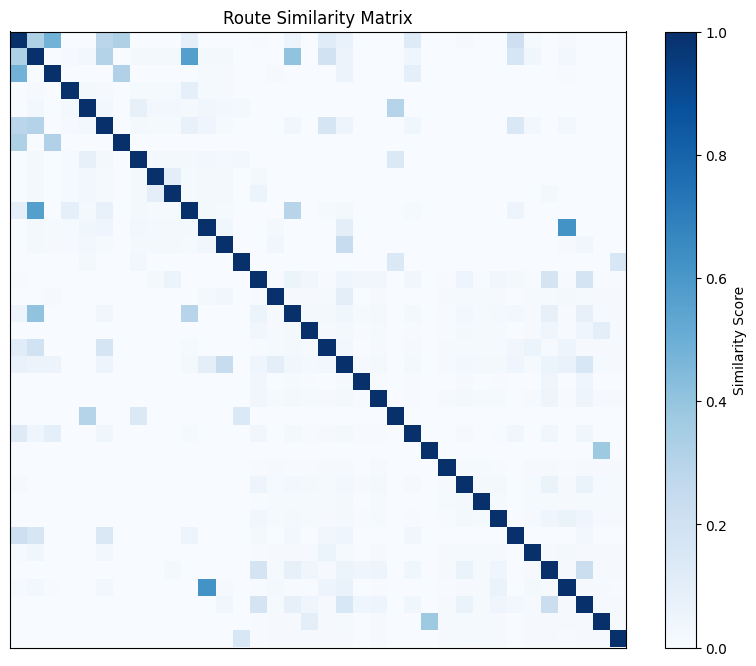

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(engine.vectorizer.route_vectors)
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="Blues")
plt.colorbar(label="Similarity Score")
plt.title("Route Similarity Matrix")

_test_routes = [r.path for r in routes_context.routes if r in test_sessions]

plt.xticks(ticks=range(len(_test_routes)), labels=_test_routes, rotation=90)
plt.yticks(ticks=range(len(_test_routes)), labels=_test_routes)

plt.show()